In [6]:
pip install skforecast

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# ----------------------------------------------------------
# Stats and Prediction
import statistics as stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# ----------------------------------------------------------
# Others
import datetime as dt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load and preprocess data from CSV file
def load_and_process_data():
    # Read the CSV file into a DataFrame
    data_frame = pd.read_csv('/content/merged_TempDemandRRPHoliday (2).csv')
    # Set 'DATETIME' as the index and convert it to DateTime type
    data_frame.set_index('DATETIME', inplace=True)
    data_frame.index = pd.to_datetime(data_frame.index)
    return data_frame


In [10]:
# Split the data into training and testing sets based on date
def split_data(df):
    # Filter rows based on the DateTime index
    training_data = df[df.index < pd.Timestamp('2021-01-01')]
    testing_data = df[df.index >= pd.Timestamp('2021-01-01')]
    return training_data, testing_data

In [11]:
# Plot the training and testing data sets
def plot_data(train_set, test_set):
    fig, ax = plt.subplots(figsize=(15, 5))
    # Plot data and set labels
    train_set['TOTALDEMAND'].plot(ax=ax, color='green')
    test_set['TOTALDEMAND'].plot(ax=ax, color='orange')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(['Training Data', 'Test Data'])
    plt.show()

In [12]:
# Create new features based on the DateTime index
def create_features(df):
    # Extract various time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [13]:
# Add lag features to the DataFrame
def add_lag_features(df):
    # Loop through different time intervals and create lag features
    for i in range(1, 6):
        days = i * 364
        df[f'lag_{i}'] = (df.index - pd.Timedelta(f'{days} days')).map(df['TOTALDEMAND'].to_dict())
    return df


In [34]:
def run_model(train_x, train_y, test_x, test_y, model=None):
    if model is None:
        model = xgb.XGBRegressor(
            base_score=0.5,
            booster='gbtree',
            n_estimators=1000,
            early_stopping_rounds=50,
            objective='reg:linear',
            max_depth=3,
            learning_rate=0.01
        )

    # Train the model

    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=100)
    predictions = model.predict(test_x)

    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    mae = mean_absolute_error(test_y, predictions)
    mape = np.mean(np.abs((test_y - predictions) / test_y)) * 100

    train_predictions = model.predict(train_x)
    train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
    train_mae = mean_absolute_error(train_y, train_predictions)
    train_mape = np.mean(np.abs((train_y - train_predictions) / train_y)) * 100

    return predictions, rmse, mae, mape, train_rmse, train_mae, train_mape


In [35]:
def add_lags(df):
    target_map = df['TOTALDEMAND'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    #df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    #df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    #df['lag4'] = (df.index - pd.Timedelta('1456 days')).map(target_map)
    #df['lag5'] = (df.index - pd.Timedelta('1820 days')).map(target_map)
    return df

In [36]:
def plot_time_series_split(df, n_splits=5):
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*365, gap=24)
    fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['TOTALDEMAND'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}', color='green')
        test['TOTALDEMAND'].plot(ax=axs[fold], label='Test Set', color='orange')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()



In [37]:
def retrain_and_forecast(df, model=None):
    FEATURES = [
         'TEMPERATURE', 'RRP', 'isHoliday','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1']
    TARGET = 'TOTALDEMAND'

    X_all = df[FEATURES]
    y_all = df[TARGET]

    if model is None:
        reg = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', n_estimators=500, max_depth=3, learning_rate=0.01)
    else:
        reg = model

    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

    future = pd.date_range('2022-08-02','2023-08-01', freq='1h')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    df_and_future = add_lags(df_and_future)

    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    future_w_features['pred'].plot(figsize=(17, 6), color='green', ms=1, lw=1, title='Future Forecast for one Years')
    plt.show()
        # Calculate additional metrics
    mape = np.mean(np.abs((y_all - y_pred) / y_all)) * 100
    test_accuracy = accuracy_score(y_all, np.round(y_pred))
    train_accuracy = accuracy_score(y_all, np.round(reg.predict(X_all)))

    print(f"MAPE for future predictions: {mape}")
    print(f"Test Accuracy for future predictions: {test_accuracy}")
    print(f"Train Accuracy for future predictions: {train_accuracy}")

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

def retrain_and_forecast(df, model=None):
    FEATURES = ['TEMPERATURE', 'RRP', 'isHoliday', 'dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1']
    TARGET = 'TOTALDEMAND'

    X_all = df[FEATURES]
    y_all = df[TARGET]

    if model is None:
        reg = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', n_estimators=500, max_depth=3, learning_rate=0.01)
    else:
        reg = model

    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

    y_pred_train = reg.predict(X_all)
    train_rmse = np.sqrt(mean_squared_error(y_all, y_pred_train))
    train_mae = mean_absolute_error(y_all, y_pred_train)
    train_mape = np.mean(np.abs((y_all - y_pred_train) / y_all)) * 100

    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train MAPE: {train_mape:.2f}%")

    # Forecasting Future
    future = pd.date_range('2022-08-02', '2023-08-01', freq='1h')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    df_and_future = add_lags(df_and_future)

    future_w_features = df_and_future.query('isFuture').copy()
    y_pred_future = reg.predict(future_w_features[FEATURES])

    future_w_features['pred'] = y_pred_future
    future_w_features['pred'].plot(figsize=(17, 6), color='green', ms=1, lw=1, title='Future Forecast for One Year')
    plt.show()

    # As y_all is the only known true value, we can't calculate RMSE, MAE, MAPE for the future predictions



In [38]:

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 8))  # Added this line to set figure size
    plt.hist(residuals, bins=30, color='green', alpha=0.7)
    plt.title('Residual Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


In [39]:

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(12, 8))  # Added this line to set figure size
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='green', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()



In [40]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

In [41]:

def grid_search_model(train_x, train_y):
    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [3, 4],
        'learning_rate': [0.01, 0.1]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)  # n_jobs=-1 uses all available cores

    grid_search.fit(train_x, train_y)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


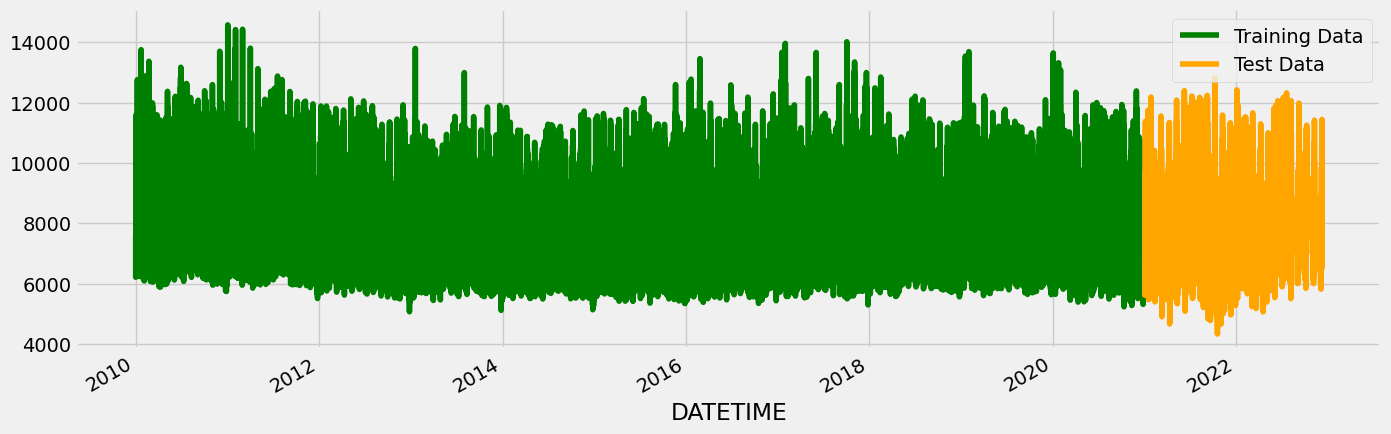

[02:56:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8184.58446	validation_1-rmse:7853.04489
[100]	validation_0-rmse:3085.38289	validation_1-rmse:2884.48570
[200]	validation_0-rmse:1310.03595	validation_1-rmse:1253.56869
[300]	validation_0-rmse:777.57666	validation_1-rmse:867.88883
[400]	validation_0-rmse:645.52443	validation_1-rmse:807.75045
[500]	validation_0-rmse:606.66812	validation_1-rmse:790.35116
[600]	validation_0-rmse:588.44764	validation_1-rmse:776.58672
[700]	validation_0-rmse:575.55956	validation_1-rmse:761.86370
[800]	validation_0-rmse:564.72955	validation_1-rmse:746.05116
[900]	validation_0-rmse:554.99670	validation_1-rmse:731.98160
[999]	validation_0-rmse:546.88603	validation_1-rmse:723.08917
[02:58:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8169.72028	validation_1-rmse:7555.93430
[100]	validati

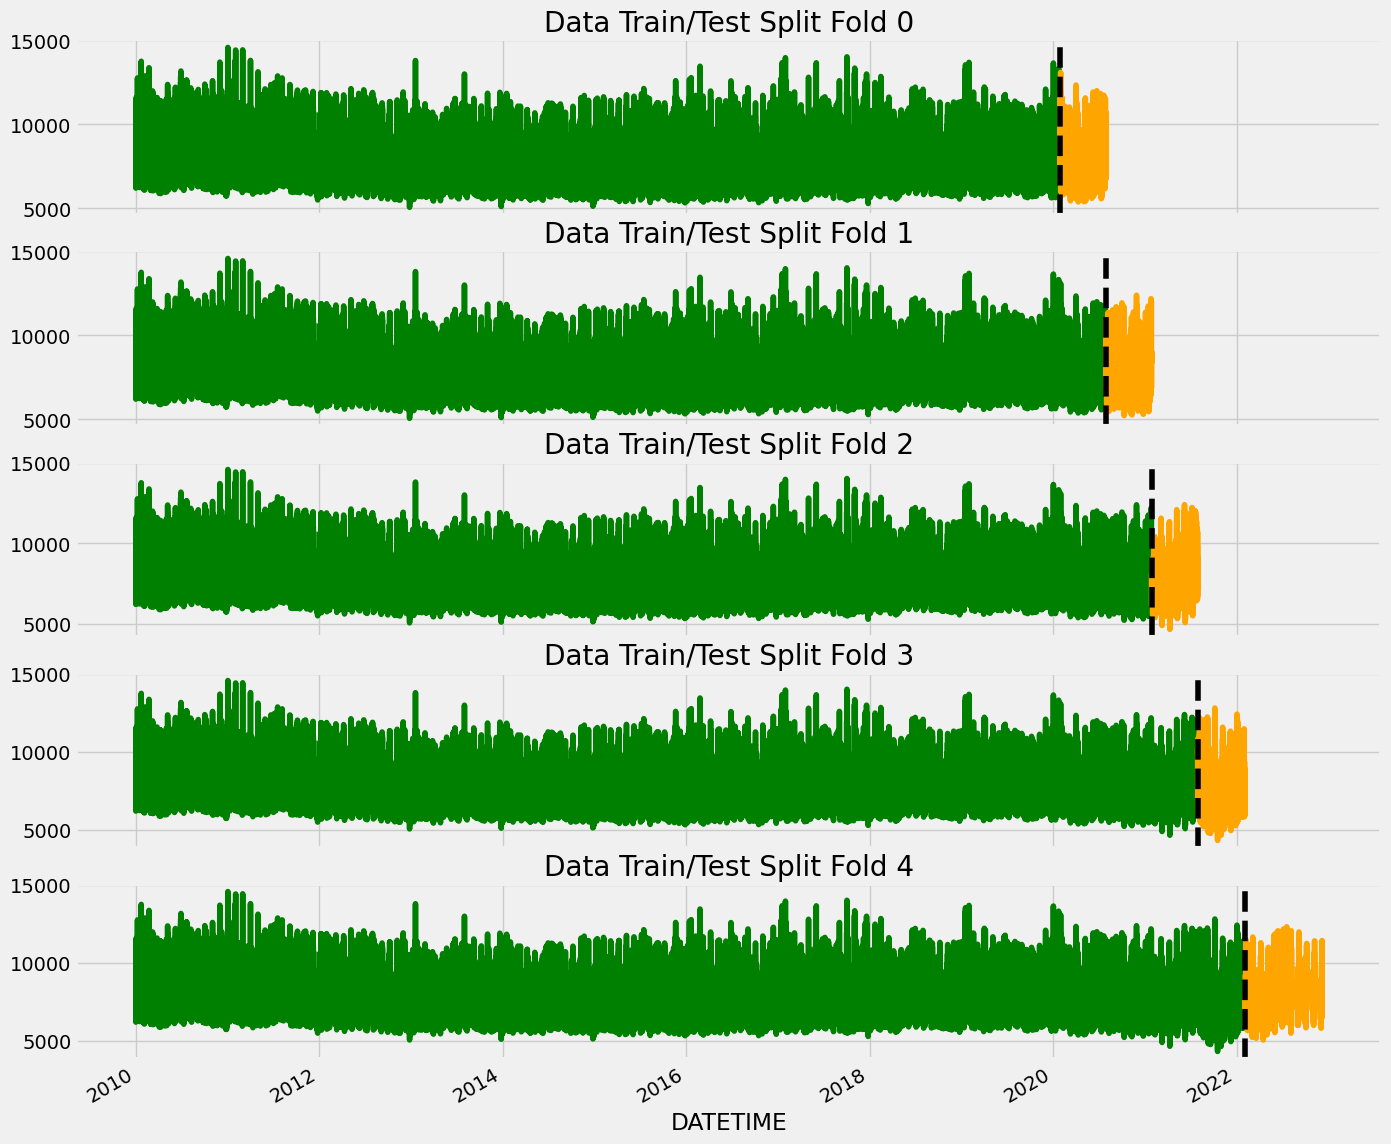

[0]	validation_0-rmse:8090.55469
[100]	validation_0-rmse:3058.39323
[200]	validation_0-rmse:1313.33717
[300]	validation_0-rmse:793.44964
[400]	validation_0-rmse:666.84981
[499]	validation_0-rmse:629.05496
Mean Absolute Error: 469.03
Root Mean Squared Error: 629.05
R-squared: 0.77


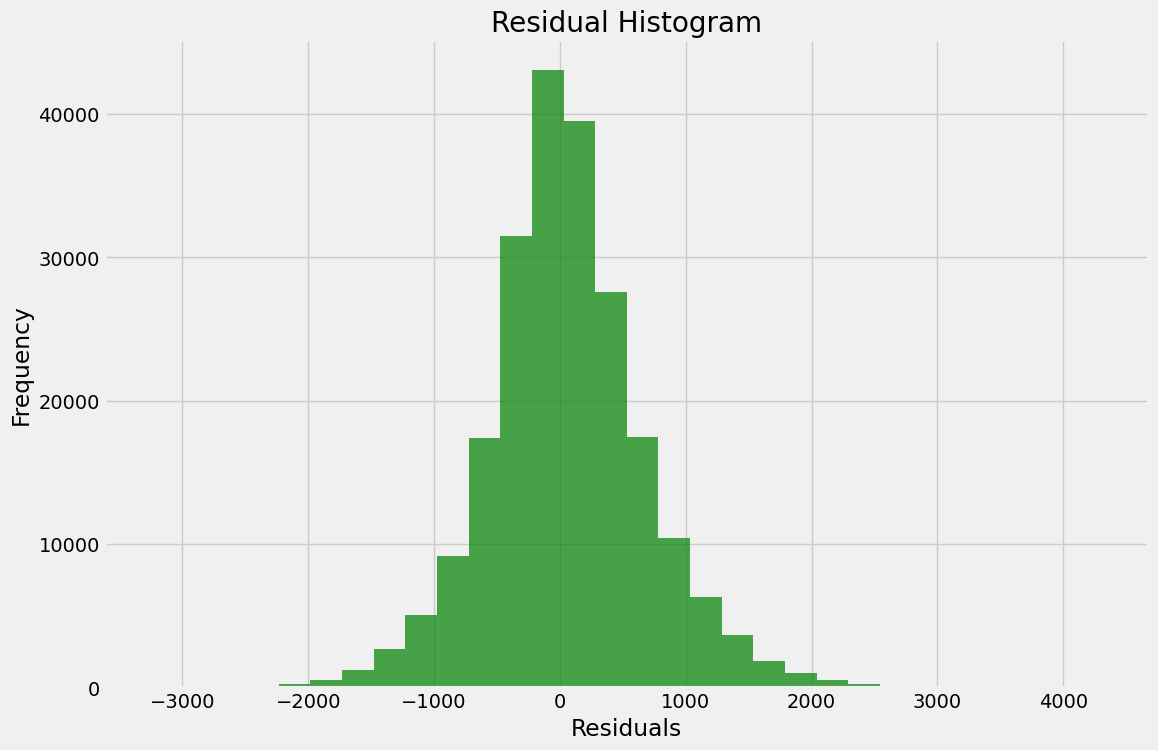

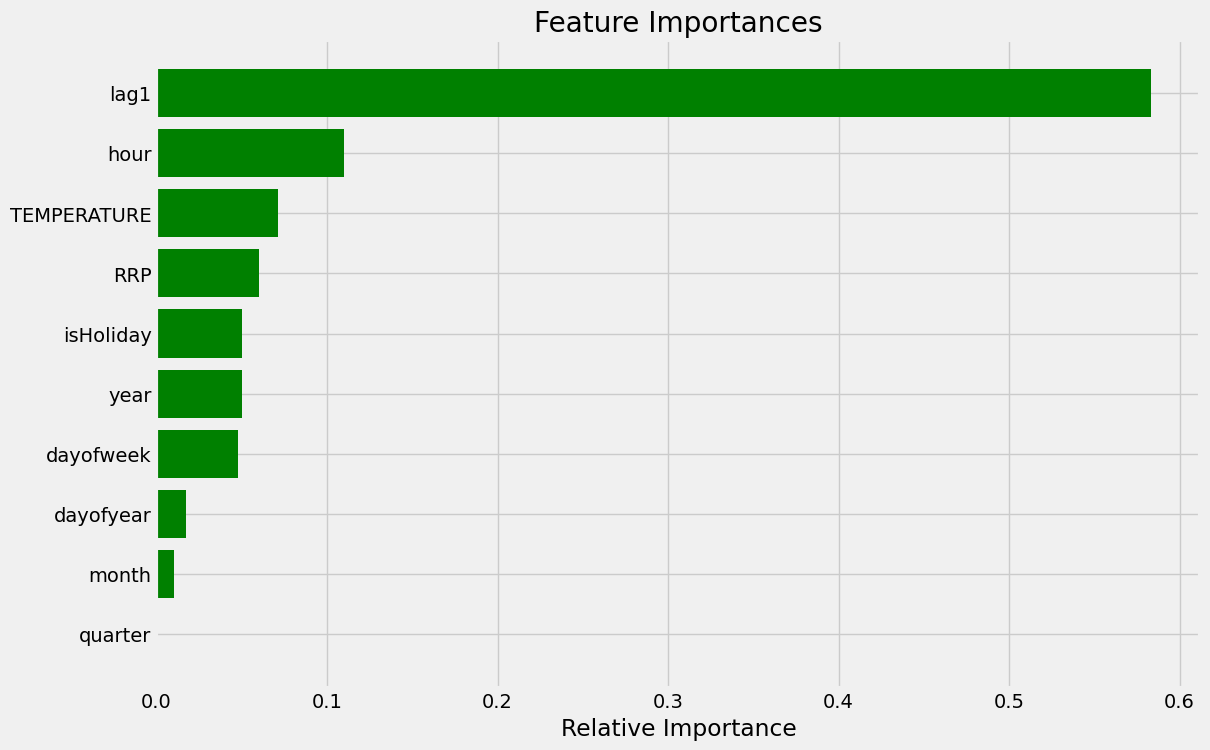

[0]	validation_0-rmse:8090.55469
[100]	validation_0-rmse:3058.39323
[200]	validation_0-rmse:1313.33717
[300]	validation_0-rmse:793.44964
[400]	validation_0-rmse:666.84981
[499]	validation_0-rmse:629.05496
Train RMSE: 629.0550
Train MAE: 469.0281
Train MAPE: 5.76%


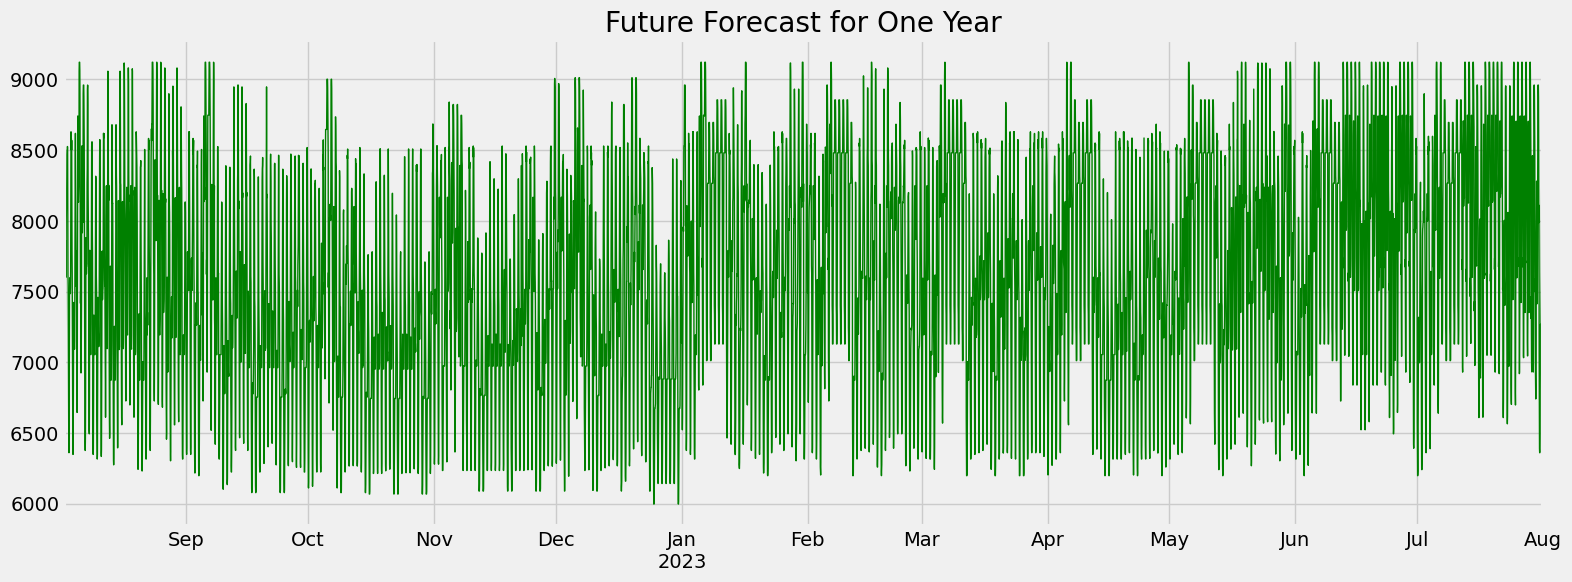

In [45]:
# Main Execution
if __name__ == "__main__":
    # Load and preprocess the data
    df = load_and_process_data()

    # Call the add_lags function
    df = add_lags(df)

    # Split the data into training and testing sets
    train_set, test_set = split_data(df)
    # Plot the data
    plot_data(train_set, test_set)

    # Initialize TimeSeriesSplit
    time_splitter = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
    df = df.sort_index()

    fold_count = 0
    pred_list = []
    rmse_list = []  # Initialize list to store RMSE
    mae_list = []   # Initialize list to store MAE
    mape_list = []  # Initialize list to store MAPE

    # Perform TimeSeriesSplit and model training
    for train_indices, test_indices in time_splitter.split(df):
        train_data = df.iloc[train_indices]
        test_data = df.iloc[test_indices]

        train_data = create_features(train_data)
        test_data = create_features(test_data)

        # Define features and target variable
        features = ['TEMPERATURE', 'RRP', 'isHoliday', 'dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1']
        target = 'TOTALDEMAND'

        train_x = train_data[features]
        train_y = train_data[target]
        test_x = test_data[features]
        test_y = test_data[target]

        # Train the model and get predictions
        pred, rmse, mae, mape, train_rmse, train_mae, train_mape = run_model(train_x, train_y, test_x, test_y)

        pred_list.append(pred)
        rmse_list.append(rmse)  # Store RMSE
        mae_list.append(mae)    # Store MAE
        mape_list.append(mape)  # Store MAPE
        fold_count += 1

    # Grid Search
    best_model, best_params, best_score = grid_search_model(train_x, train_y)
    print(f"Best Parameters: {best_params}")
    print(f"Best Grid Search Score: {best_score:.4f}")

    # Retrain with best model
    pred, rmse, mae, mape, train_rmse, train_mae, train_mape = run_model(train_x, train_y, test_x, test_y)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train MAPE: {train_mape:.2f}%")

    # Plot Time Series Splits
    plot_time_series_split(df)

    # Retrain and Forecast
    df = create_features(df)
    FEATURES = ['TEMPERATURE', 'RRP', 'isHoliday', 'dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1']
    TARGET = 'TOTALDEMAND'

    X_all = df[FEATURES]
    y_all = df[TARGET]
    reg = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', n_estimators=500, max_depth=3, learning_rate=0.01)

    reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

    # Calculate Metrics
    y_pred = reg.predict(X_all)
    calculate_metrics(y_all, y_pred)

    # Visualizations
    plot_residuals(y_all, y_pred)
    plot_feature_importance(reg, FEATURES)

    # Retrain and Forecast
    #retrain_and_forecast(df, model=best_model)
    retrain_and_forecast(df, model=None)
